In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import lib.plot_mpl as p
from imp import reload
from id01lib.xrd import qconversion as q
import xrayutilities as xu
from id01sware.id01lib.xrd.qconversion import get_qspace_vals
from id01sware.id01lib.xrd.detectors import MaxiPix
from id01sware.id01lib.xrd.geometries import ID01psic
from ipywidgets import interact


/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
h5file = './20180412_HC3505_e17089.h5'
scans = [16,17,18]
sdata = c.stitch_scans(h5file,'e17089',scans)

In [15]:
def qconvert_stitched(fname, sample, image_data, scans, cen_pix_x, cen_pix_y, distance, geometry, nbins, maxbins=False):

    # Init values 
    detector = MaxiPix()
    energy = 8000
    ipdir = [1,0,0]
    ndir = [0,0,1]

    # Read out positioners from h5
    motors = dict()
    with h5py.File(fname,'r') as h5f:
        pos = h5f[str(sample)+'/'+str(scans[0])+'.1/instrument/positioners']
        for motor in pos:
            motors[motor] = pos[motor].value

    # add mpx offset to central pixel (as meas from det_calib)
    cen_pix_y += motors["mpxz"]/1000. / detector.pixsize[0]
    cen_pix_x -= motors["mpxy"]/1000. / detector.pixsize[1]

    # initialise the experiment class feeding the ID01psic geometry to it
    hxrd = xu.HXRD([1,0,0], [0,0,1], en=8000, qconv=geometry.getQconversion())

    # select the whole detector as the roi
    roi = [0, detector.pixnum[0], 0, detector.pixnum[1]]

    # initalise the area detector
    hxrd.Ang2Q.init_area(detector.directions[0],
                         detector.directions[1],
                         cch1=cen_pix_x,
                         cch2=cen_pix_y,
                         Nch1=detector.pixnum[0],
                         Nch2=detector.pixnum[1],
                         pwidth1=detector.pixsize[0],
                         pwidth2=detector.pixsize[1],
                         distance=distance,
                         roi=roi)

    # get the angles of the ID01psic geometry
    angles = geometry.sample_rot.copy()
    angles.update(geometry.detector_rot)

    # Get eta values and stitch them
    with h5py.File(fname,'r') as h5f:
        eta_vals = []
        for scan in scans:
            eta_vals.append(h5f[str(sample)+'/'+str(scan)+'.1/instrument/positioners/eta'].value)
        eta = np.concatenate((eta_vals))

    # Get the rest of the positioners and correct them for offsets
    maxlen = 1
    motors['eta'] = eta.astype('float32') 
    for angle in angles:
        if angle in geometry.usemotors:
            # fetch experimental angle value
            dset = motors[angle if angle is not "delta" else "del"]
            if len(dset.shape): # if it's 0 motor is still, if it's 1 motor is changing during scan
                maxlen = max(maxlen, dset.shape[0])
            position = dset
        else:
            position = 0.
        angles[angle] = position - geometry.offsets[angle]

    print('Offsets used: \n')
    for key, value in geometry.offsets.items():
        print('{0} = {1}'.format(key, value))
    # output: ordered dict with offset corrected angles of interest used during a scan.

    # if the angle is kept constant during a scan, it is a scalar. If that's the case,
    # make it the same shape as the angle(s) which is being varied during a scan
    for angle in angles:
        if np.isscalar(angles[angle]):
            angles[angle] = np.ones(maxlen, dtype=np.float32) * angles[angle]

    # The actual conversion
    qx, qy, qz = hxrd.Ang2Q.area(*angles.values())
    qx, qy, qz = qx.astype('float32'), qy.astype('float32'), qz.astype('float32')

    # calc max bins -- THIS IS SUPER SLOW?
    if maxbins:
        maxbins = []
        safemax = lambda arr: arr.max() if arr.size else 0
        for dim in (qx, qy, qz):
            maxstep = max((safemax(abs(np.diff(dim, axis=j))) for j in range(3)))
            maxbins.append(int(abs(dim.max()-dim.min())/maxstep))
    else:
        maxbins = nbins
    

    # load images in scan
    num_im = image_data.shape[0]
    for idx in range(num_im):
        frame = image_data[idx]
        detector.correct_image(frame) # remove gaps
        if not idx: # first iteration
            # create cube of empty data
            intensity = np.empty((num_im, frame.shape[0], frame.shape[1])).astype('float32')
            intensity[idx] = frame.astype('float32')
        else:
            intensity[idx,:,:] = frame.astype('float32')
    
    # grid data
    gridder = xu.Gridder3D(*maxbins)
    gridder(qx, qy, qz, intensity)

    return (gridder.xaxis.astype('float32'), gridder.yaxis.astype('float32'),
            gridder.zaxis.astype('float32'), gridder.data.astype('float32'))

In [16]:
def qconvert_mgrid(qx, qy, qz, gint, *args):
    nx, ny, nz = gint.shape
    print('\nUsing nbins: {0}'.format(gint.shape))
    QX,QY,QZ = np.mgrid[qx.min():qx.max():1j * nx,
                        qy.min():qy.max():1j * ny,
                        qz.min():qz.max():1j * nz]
    INT = xu.maplog(gint, *args)
    
    return QX, QY, QZ, INT

In [17]:
## init
eta_off = 0
det_distance =  0.398
cen_pix = [298.956,352.283] # x, y
nrj=8
nbins = [300,300,300]
geometry = q.ID01psic()

## Sample and scans
fname = h5file
sample = 'e17089'

## set offsets
with h5py.File(fname,'r') as h5f:
    phi_off = h5f[str(sample)+'/'+str(scans[0])+'.1/instrument/positioners/phi'].value
    rhx_off = h5f[str(sample)+'/'+str(scans[0])+'.1/instrument/positioners/rhx'].value
    rhy_off = h5f[str(sample)+'/'+str(scans[0])+'.1/instrument/positioners/rhy'].value
    nu_off =  h5f[str(sample)+'/'+str(scans[0])+'.1/instrument/positioners/nu'].value
geometry.usemotors = set(('eta', 'phi', 'nu', 'delta'))
geometry.set_offsets(eta=eta_off, rhy=0, rhx=0, phi=0, nu=nu_off)

# calc
qx, qy, qz, gint = qconvert_stitched(fname, sample, sdata, scans, cen_pix[1], cen_pix[0], det_distance, geometry, nbins, maxbins=True)

Offsets used: 

eta = 0.0
nu = 0.0
rhy = 0.0
rhz = 0.0
mu = 0.0
delta = 0.0
rhx = 0.0
phi = 0.0


In [18]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.5)
print('min: {0}; max: {1}; mean{2}'.format(i.min(), i.max(), i.mean()))


Using nbins: (309, 520, 612)
min: 5.997025966644287; max: 10.497026443481445; mean5.996726989746094


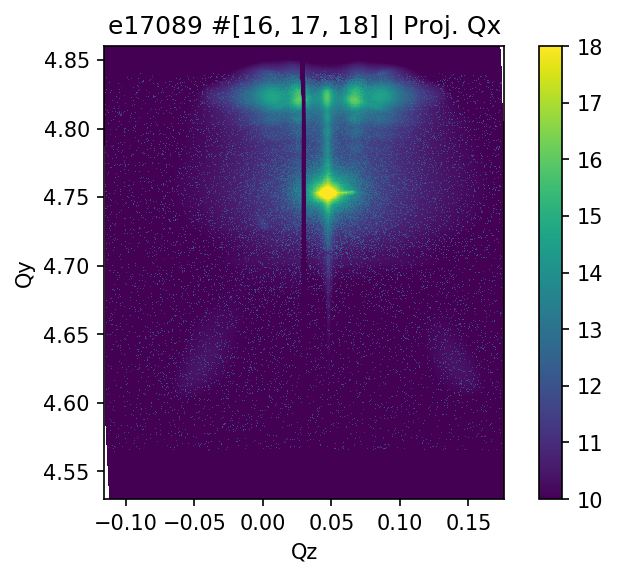

In [19]:
%matplotlib inline
# along x
s1 = 120
s2 = 350
# plt.title('Projection from Qz={0:.3f}'.format(qz[200]))
plt.figure(dpi=150)
plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],np.log(gint[:,:,:].sum(0)),vmin=10,vmax=18)
# plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],i[:,:,:].sum(0))
plt.title('{0} #{1} | Proj. Qx'.format(sample, scans))
plt.ylabel('Qy')
plt.xlabel('Qz')
plt.axis('image')
plt.colorbar();

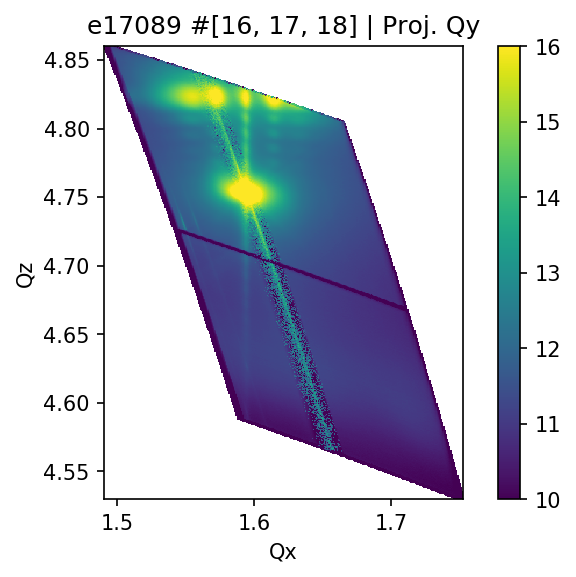

In [23]:
## along y
# s=296
plt.figure(dpi=150)
# plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],i[:,:,:].sum(1));
plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],np.log(gint[:,:,:].sum(1)),vmin=10,vmax=16)
plt.title('{0} #{1} | Proj. Qy'.format(sample, scans))
plt.ylabel('Qz')
plt.xlabel('Qx')
plt.axis('image')
plt.colorbar()

Text(0.5,0,'Qz')

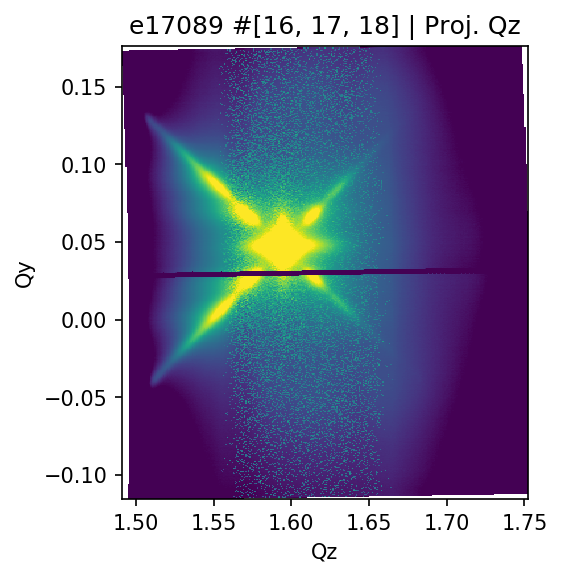

In [21]:
# # along z
plt.figure(dpi=150)
s = 0
if s != 0:
    plt.title('Projection up to c={0:.3f}'.format(4*np.pi/qz[s]))
else:
    plt.title('{0} #{1} | Proj. Qz'.format(sample, scans))
# plt.pcolormesh(qxx[:,:,0],qyy[:,:,0],i[:,:,:s].sum(2))
plt.pcolormesh(qxx[:,:,0],qyy[:,:,0],np.log(gint[:,:,:].sum(2)),vmin=10, vmax=15)
plt.axis('image');
plt.ylabel('Qy')
plt.xlabel('Qz')

In [22]:
%matplotlib inline
# along z
@interact(s=(0,i.shape[2]))
def plot(s=10):
    plt.figure(figsize=(4.6*2,3*2),dpi=100)
    plt.title('Slice @ Qz={0:.3f}'.format(qzz[0,0,s]))
    plt.pcolormesh(qxx[:,:,0], qyy[:,:,0],np.log(gint[:-1,:-1,s]),vmin=2,vmax=8);
    bar = plt.colorbar()
    bar.set_label('ln(I)')
    plt.axis('image')
    plt.ylabel('Qy')
    plt.xlabel('Qx')
    plt.tight_layout();

interactive(children=(IntSlider(value=10, description='s', max=612), Output()), _dom_classes=('widget-interact',))

<Figure size 920x600 with 0 Axes>